# Code

In [1]:
from plot_setup import * 
import MCgenerator, dSph_model, coord

In [2]:
prms = {
    "re":r"$r_e[\mathrm{pc}]$",
    "sigmafg":r"\tilde{\Sigma}_\mathrm{FG}"
}
dSph_property = pd.read_csv("dSph_property.csv",index_col=0)
draco_prop = dSph_property.loc["Draco"]
RA0 = draco_prop.RAdeg
DE0 = draco_prop.DEdeg
DIST = draco_prop.DIST
dSph_property

,RAh,RAm,RAs,pmDEd,DEm,DEs,DIST,HLR,RAdeg,DEdeg
Draco,17,20,12,57,54,55,76000.0,221.0,260.05,57.915278


In [4]:
SPECIFY_NAME = "refR-re-w-center"
FNAME_BASE = "MCMCresult/MCMC{}_{}_{}.csv"
VERSION="v002"
# v001: for mycut
# v002: for spectroscopy cut

In [5]:
class KI17_loglikelihood_mod:
    def __init__(self,dRAs,dDEs):
        self.dRAs = dRAs
        self.dDEs = dDEs
        self.RoI_R = np.max(self.Rs(0,0)) # use Rs.max as the RoI
        print(Rs.describe())
        self.mem = dSph_model.plummer_model(re_pc=100)
        self.fg = dSph_model.uniform2d_model(Rmax_pc=self.RoI_R)

    def Rs(self,dra0,dde0):
        return coord.projected_distance(
            dist=DIST,
            ra_center = RA0+dra0,
            de_center = DE0+dde0,
            ra = RA0+self.dRAs,
            de = DE0+self.dDEs,
            dtype="deg")
        
    def __call__(self,re,odds,dra0,dde0):
        if re<0 or odds<0:
            return -np.inf
        else:
            mem,fg = self.mem,self.fg
            mem.update({"re_pc":re})
            ref_R = re
            
            C1 = 1/mem.cdf_R(self.RoI_R)
            C0 = fg.density_2d(self.RoI_R) # fg.density_2d returns constant for arbitrary input
            #s = C0/(sigmafg*mem.density_2d(self.Rs)*C1 + C0)
            #s = C0/(sigmafg*mem.density_2d(self.Rs)*C1)
            s = 1/(1+ 1/odds * mem.density_2d(ref_R)/mem.mean_density_2d(self.RoI_R))
            
            arg_proj_dist_deg = {
                "ra":self.dRAs+RA0,"de":self.dDEs+DE0,
                "ra_center":RA0+dra0,"de_center":DE0+dde0
            }
            Rs = coord.projected_distance(dist=DIST,**arg_proj_dist_deg,dtype="deg")
            
            loglikelis = np.log(s*C1*mem.density_2d(Rs)+(1-s)*C0)
            return np.sum(loglikelis)
    def loglikelis(self,re,odds,dra0,dde0):
        if re<0 or odds<0:
            return -np.inf
        else:
            mem,fg = self.mem,self.fg
            mem.update({"re_pc":re})
            ref_R = re
            
            C1 = 1/mem.cdf_R(self.RoI_R)
            C0 = fg.density_2d(self.RoI_R) # fg.density_2d returns constant for arbitrary input
            #s = C0/(sigmafg*mem.density_2d(self.Rs)*C1 + C0)
            #s = C0/(sigmafg*mem.density_2d(self.Rs)*C1)
            s = 1/(1+ 1/odds * mem.density_2d(ref_R)/mem.mean_density_2d(self.RoI_R))
            
            arg_proj_dist_deg = {
                "ra":self.dRAs+RA0,"de":self.dDEs+DE0,
                "ra_center":RA0+dra0,"de_center":DE0+dde0
            }
            Rs = coord.projected_distance(dist=DIST,**arg_proj_dist_deg,dtype="deg")
            ret = np.log(s*C1*mem.density_2d(Rs)+(1-s)*C0)

            return ret


In [52]:
class KI17_loglikelihood:
    def __init__(self,Rs):
        self.Rs = Rs
        self.RoI_R = np.max(Rs) # use Rs.max as the RoI
        print(self.Rs)
        self.mem = dSph_model.plummer_model(re_pc=100)
        self.fg = dSph_model.uniform2d_model(Rmax_pc=self.RoI_R)

    def __call__(self,re,s):
        if re<0 or not 0<s<1:
            return -np.inf
        else:
            mem,fg = self.mem,self.fg
            mem.update({"re_pc":re})
            ref_R = re
            
            C1 = 1/mem.cdf_R(self.RoI_R)
            C0 = fg.density_2d(self.RoI_R) # fg.density_2d returns constant for arbitrary input
            #s = C0/(sigmafg*mem.density_2d(self.Rs)*C1 + C0)
            #s = C0/(sigmafg*mem.density_2d(self.Rs)*C1)
            #s = 1/(1+ 1/odds * mem.density_2d(ref_R)/mem.mean_density_2d(self.RoI_R))
            
            loglikelis = np.log(2*np.pi*self.Rs)+np.log(s*C1*mem.density_2d(self.Rs)+(1-s)*C0)
            return np.sum(loglikelis)
    def loglikelis(self,re,s):
        if re<0 or not 0<s<1:
            return -np.inf
        else:
            mem,fg = self.mem,self.fg
            mem.update({"re_pc":re})
            ref_R = re
            
            C1 = 1/mem.cdf_R(self.RoI_R)
            C0 = fg.density_2d(self.RoI_R) # fg.density_2d returns constant for arbitrary input
            #s = C0/(sigmafg*mem.density_2d(self.Rs)*C1 + C0)
            #s = C0/(sigmafg*mem.density_2d(self.Rs)*C1)
            #s = 1/(1+ 1/odds * mem.density_2d(ref_R)/mem.mean_density_2d(self.RoI_R))
            
            ret = np.log(2*np.pi*self.Rs)+np.log(s*C1*mem.density_2d(self.Rs)+(1-s)*C0)
            return ret
    def s_to_odds(self,s,ref_R):
        mem,fg = self.mem,self.fg
        return mem.density_2d(ref_R)/mem.mean_density_2d(self.RoI_R)/(1/s-1)

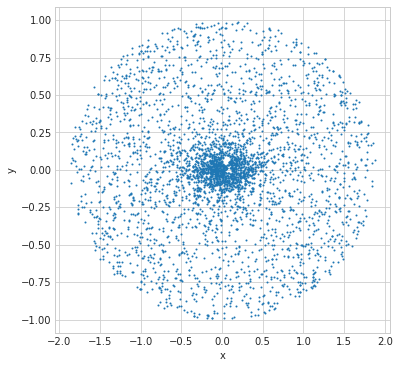

In [6]:
df0 = np.loadtxt("Draco_SDSS_cut_xy1.0.csv",comments="#",delimiter=",")
df_deg = pd.DataFrame(df0,columns=("x","y"))
df_rad = np.deg2rad(pd.DataFrame(df0,columns=("x","y")))

#ra = coord.hms_to_deg(df.RAh,df.RAm,df.RAs) + ra0
#de = coord.dms_to_deg(df.pmDEd,df.DEm,df.DEs) + de0
ra = df_deg.x + RA0
de = df_deg.y + DE0


arg_proj_dist = {
    "ra":ra,"de":de,
    "ra_center":RA0,"de_center":DE0
}
angles = coord.projected_angle(**arg_proj_dist,dtype="deg")
Rs = coord.projected_distance(dist=DIST,**arg_proj_dist,dtype="deg")
distort = np.cos(np.deg2rad(draco_prop.DEdeg))
deg_max = 1
df_deg[(np.abs(df_deg.x)<deg_max/distort).values * (np.abs(df_deg.y)<deg_max).values].plot.scatter("x","y",s=1,figsize=(6,6))

## density of ofserbed stars

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f635fd87f60>]],
      dtype=object)

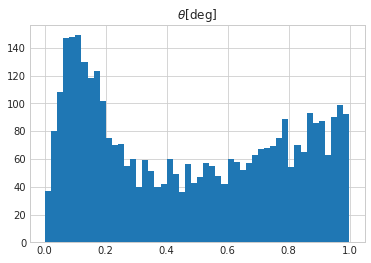

In [7]:
pd.DataFrame({r"$\theta$[deg]":angles}).hist(bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f639d2d5a90>]],
      dtype=object)

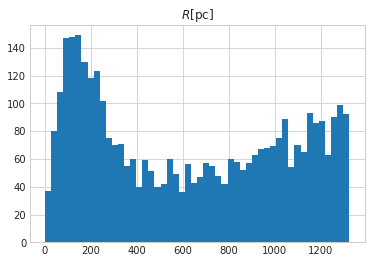

In [8]:
pd.DataFrame({r"$R$[pc]":Rs}).hist(bins=50)

## definition of likelihood

In [9]:
loglikeli = KI17_loglikelihood_mod(dRAs=df_deg.x[angles<1.0],dDEs=df_deg.y[angles<1.0])
#loglikeli = KI17_loglikelihood(Rs[angles<1.0])

count    3655.000000
mean      625.164179
std       421.068471
min         1.698731
25%       211.871502
50%       596.463856
75%      1023.876544
max      1325.086262
dtype: float64


In [10]:
gen = MCgenerator.MCgenerator(
    args_logpdf_init={"re":180,"odds":6.5,"dra0":0.0,"dde0":0.0},
    dargs_logpdf={"re":5.0,"odds":0.5,"dra0":0.01,"dde0":0.01},
    logpdf_func=loglikeli
)

initialization of MCgenerator start.
function loaded.
logpdf_initialization completed.
Data chains are initialized.
MCparameters are initialized.


In [11]:
Nstep_init = 5000
gen.generate(Nstep_init)

MCgeneration start.
options: {}
73.000% completed... acceptance rate: 15.64%
MCgeneration end.
MCresults are stored.
MCinfo are logged.
   dde0  dra0  odds   re  iter_num
0  0.01  0.01   0.5  5.0      5000


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f635fb8f128>,
      dtype=object)

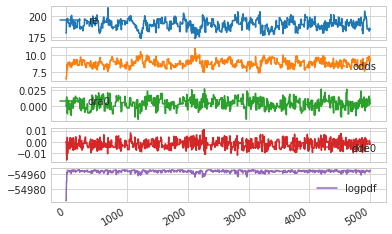

In [12]:
gen.to_DataFrame().plot(subplots=True)

In [13]:
gen.generate_tuned((5000,5000,5000))

MCgeneration start.
options: {}
73.540% completed... acceptance rate: 17.00%
MCgeneration end.
MCresults are stored.
MCinfo are logged.
   dde0  dra0  odds   re  iter_num
0  0.01  0.01   0.5  5.0      5000
1  0.01  0.01   0.5  5.0      5000
0th iteration: update dargs_logpdf. 
before:
re      5.00
odds    0.50
dra0    0.01
dde0    0.01
dtype: float64
after:
re      6.101275
odds    0.538013
dra0    0.007200
dde0    0.003449
dtype: float64
MCgeneration start.
options: {}
73.520% completed... acceptance rate: 30.63%
MCgeneration end.
MCresults are stored.
MCinfo are logged.
       dde0    dra0      odds        re  iter_num
0  0.010000  0.0100  0.500000  5.000000      5000
1  0.010000  0.0100  0.500000  5.000000      5000
2  0.003449  0.0072  0.538013  6.101275      5000
1th iteration: update dargs_logpdf. 
before:
re      6.101275
odds    0.538013
dra0    0.007200
dde0    0.003449
dtype: float64
after:
re      5.673372
odds    0.509708
dra0    0.006654
dde0    0.003094
dtype: float64
MCg

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f635fa77940>,
      dtype=object)

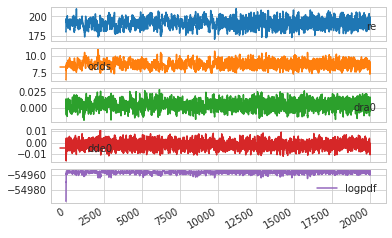

In [14]:
gen.to_DataFrame()[:].plot(subplots=True)

In [15]:
gen.options["push_time"] = 30
gen.generate(200000)

MCgeneration start.
options: {'push_time': 30}
5.454% completed... acceptance rate: 33.20%
10.911% completed... acceptance rate: 33.02%
16.403% completed... acceptance rate: 33.30%
21.907% completed... acceptance rate: 33.60%
27.384% completed... acceptance rate: 33.69%
32.889% completed... acceptance rate: 33.69%
38.352% completed... acceptance rate: 33.61%
43.856% completed... acceptance rate: 33.64%
49.347% completed... acceptance rate: 33.66%
54.831% completed... acceptance rate: 33.60%
60.328% completed... acceptance rate: 33.71%
65.829% completed... acceptance rate: 33.67%
71.311% completed... acceptance rate: 33.67%
76.816% completed... acceptance rate: 33.61%
82.321% completed... acceptance rate: 33.58%
87.814% completed... acceptance rate: 33.60%
93.295% completed... acceptance rate: 33.64%
98.760% completed... acceptance rate: 33.64%
MCgeneration end.
MCresults are stored.
MCinfo are logged.
       dde0      dra0      odds        re  iter_num
0  0.010000  0.010000  0.500000  

## results

In [25]:
result_df = gen.to_DataFrame()
resultlog_df = gen.to_DataFrame(output_log=True)
resultlog_df

,dde0,dra0,odds,re,iter_num
0,0.010000,0.010000,0.500000,5.000000,5000
1,0.010000,0.010000,0.500000,5.000000,5000
2,0.003466,0.007251,0.375037,5.293312,5000
3,0.003569,0.007769,0.419223,6.413361,5000
4,0.003483,0.007991,0.424957,6.163378,200000


if you already done the calculation, load the result below.

In [7]:
#result_df = pd.read_csv("MCMCresult/MCMC_refR-re-w-center_v001.csv")
#resultlog_df = pd.read_csv("MCMCresult/MCMClog_refR-re-w-center_v001.csv")

print last 200000 steps


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7548d78e48>,
      dtype=object)

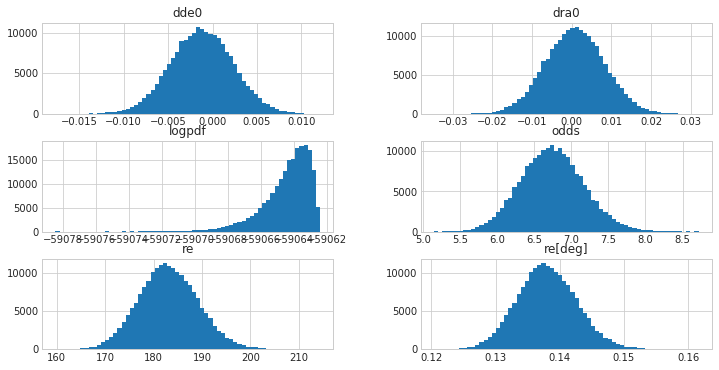

In [8]:
ploted_stepset = 1
last_MCMC_steps = np.sum(resultlog_df.iter_num.values[-ploted_stepset:])
print("print last {} steps".format(last_MCMC_steps))
#result_df["re[deg]"] = np.rad2deg(result_df.re/draco_prop.DIST)
result_df[-last_MCMC_steps:].hist(bins=64,figsize=(12,6))

Note: The following warnings occur, but no problem.


/home/gomesu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/home/gomesu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/home/gomesu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/home/gomesu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/home/gomesu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/home/gomesu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/contou

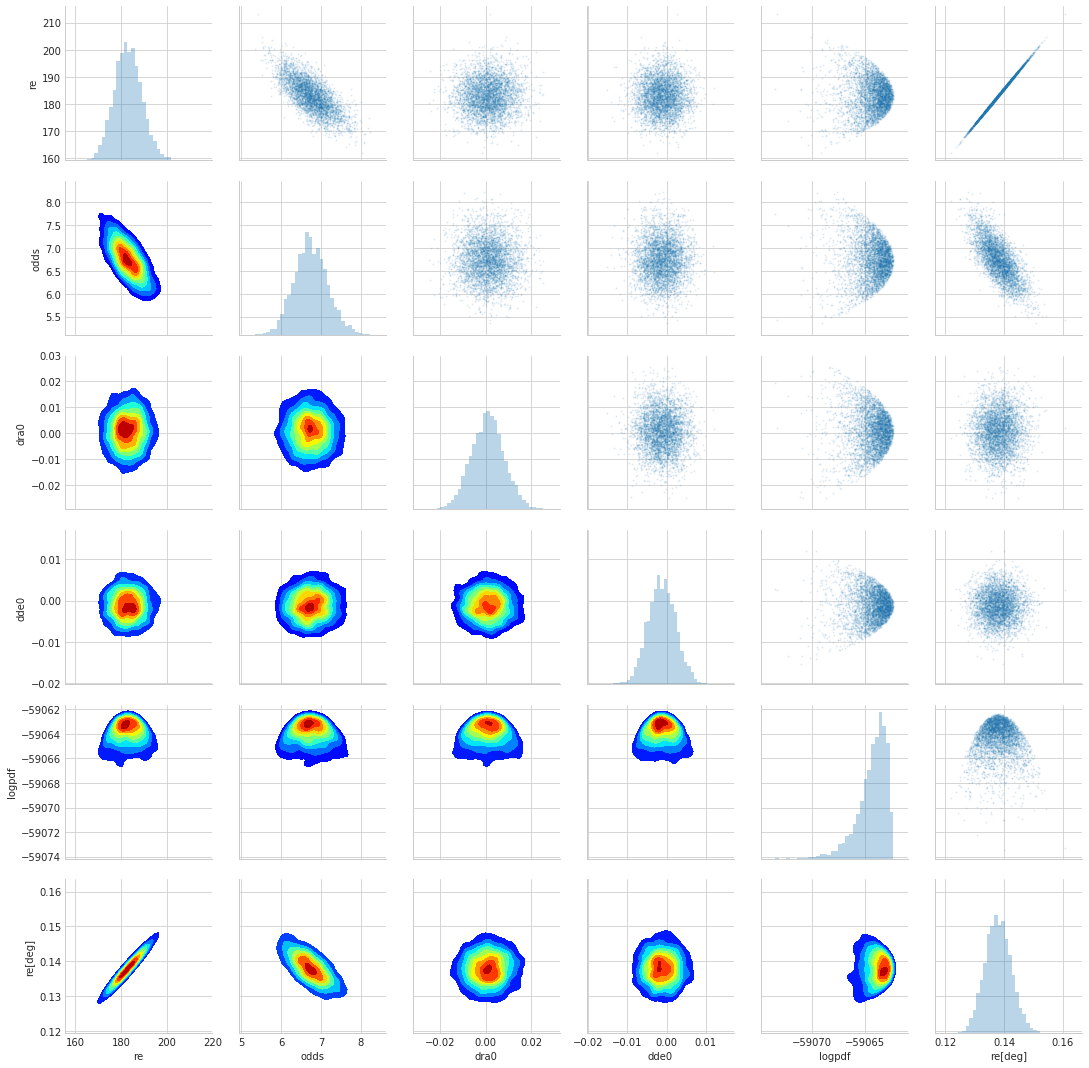

In [28]:
mypairplot(result_df[-200000::50])
#mypairplot(result_df[-lastMCMCsteps])

In [9]:
stats = result_df[-last_MCMC_steps:].describe(percentiles=(0.16,0.5,0.84))
stats

,re,odds,dra0,dde0,logpdf,re[deg]
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,183.105747,6.740206,0.000838,-0.001213,-59064.414305,0.138042
std,6.128326,0.423968,0.007483,0.003512,1.442083,0.004620
min,159.708577,5.143589,-0.034756,-0.017679,-59078.429188,0.120403
16%,177.038396,6.317799,-0.006632,-0.004712,-59065.720804,0.133468
50%,182.945978,6.732905,0.000832,-0.001215,-59064.088430,0.137921
84%,189.167818,7.157436,0.008226,0.002259,-59063.106852,0.142612
max,214.401620,8.716415,0.031959,0.012108,-59062.396406,0.161636


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7543fd12e8>],
      dtype=object)

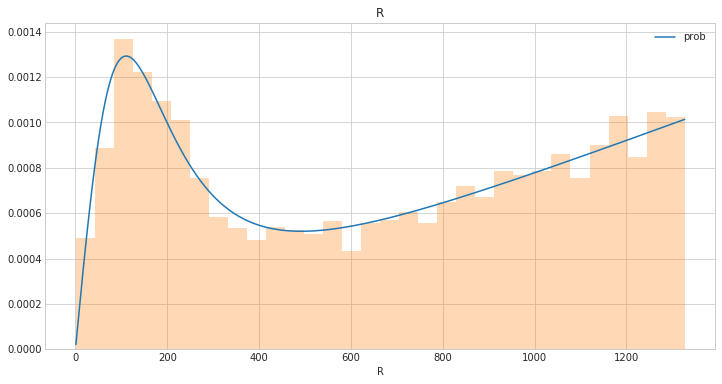

In [27]:
plots_likelis = pd.DataFrame()
#plots_likelis["R"] = Rs # ideally loglikeli.R but approzimately here we use Rs
plots_likelis["R"] = loglikeli.Rs(dra0=stats.dra0.loc["50%"],dde0=stats.dde0.loc["50%"])
plots_likelis["prob"] = np.exp(np.log(2*np.pi*plots_likelis.R)+loglikeli.loglikelis(**(stats[["re","odds","dra0","dde0"]].loc["50%"])))
plots_likelis = plots_likelis.sort_values(by="R")

fig,ax = plt.subplots()
plots_likelis[::].plot(x="R",y="prob",ax=ax,figsize=(12,6))
display(plots_likelis[::].hist("R",bins=32,density=True,alpha=0.3,ax=ax))

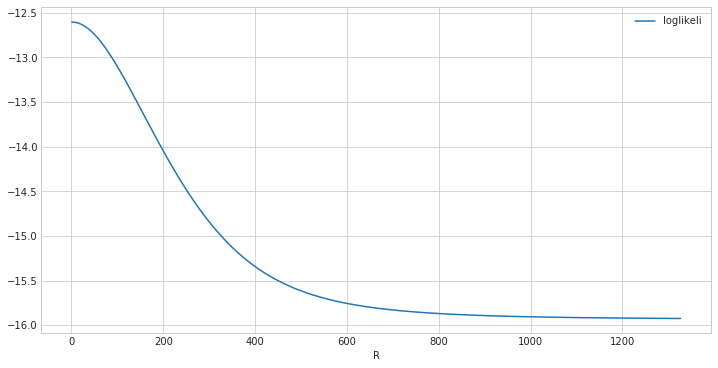

In [28]:
plots_loglikelis = pd.DataFrame()
plots_loglikelis["R"] = loglikeli.Rs(dra0=stats.dra0.loc["50%"],dde0=stats.dde0.loc["50%"]) # ideally loglikeli.R but approzimately here we use Rs
plots_loglikelis["loglikeli"] = loglikeli.loglikelis(**(stats[["re","odds","dra0","dde0"]].loc["50%"]))
plots_loglikelis = plots_loglikelis.sort_values(by="R")

fig,ax = plt.subplots()
plots_loglikelis[::].plot(x="R",y="loglikeli",ax=ax,figsize=(12,6))

## export

In [64]:
fname = FNAME_BASE
specify_name = SPECIFY_NAME
version = VERSION
result_df.to_csv(fname.format("",specify_name,version),index=None)
resultlog_df.to_csv(fname.format("log",specify_name,version),index=None)

# Compare to other results

,odds,re,iter_num
0,0.500000,5.000000,5000
1,0.500000,5.000000,5000
2,0.398303,6.137237,10000
3,0.419732,6.039228,100000
4,0.419732,6.039228,100000


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2ea489d6a0>,
      dtype=object)

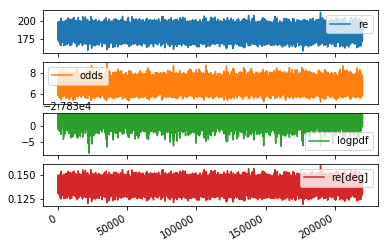

In [54]:
fname_base = "MCMCresult/MCMC{}_{}_{}.csv"
df = pd.read_csv(fname_base.format("","refR-re","v001"))
logdf = pd.read_csv(fname_base.format("log","refR-re","v001"))
display(logdf)
df.plot(subplots=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2ea46e77f0>,
      dtype=object)

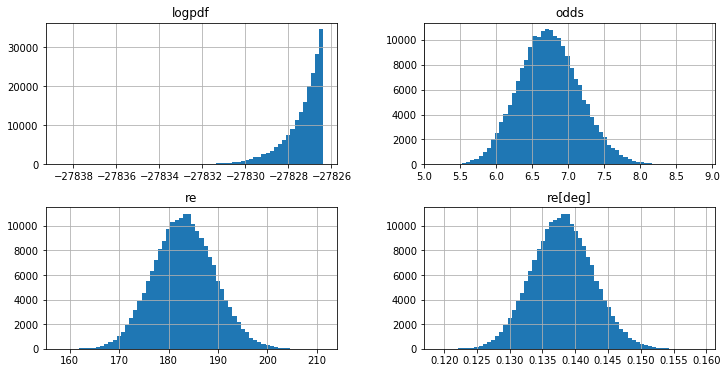

In [56]:
ploted_steps_num = 2
ploted_steps = np.sum(logdf.iter_num[-ploted_steps_num:])
df[-ploted_steps:].hist(bins=64,figsize=(12,6))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f841463d5c0>,
      dtype=object)

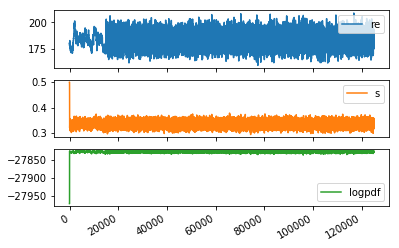

In [25]:
fname_base = "MCMCresult/MCMC{}_{}_{}.csv"
df2 = pd.read_csv(fname_base.format("","KI17","v001"))
logdf2 = pd.read_csv(fname_base.format("log","KI17","v001"))
df2.plot(subplots=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8416843208>,
      dtype=object)

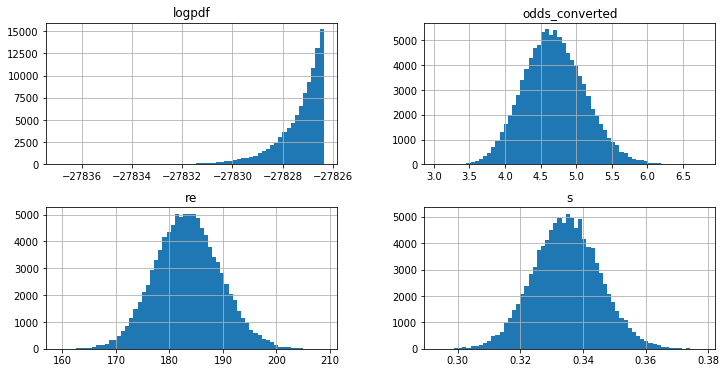

In [47]:
df2[-100000:].hist(bins=64,figsize=(12,6))

In [46]:
df2["odds_converted"]=loglikeli.s_to_odds(df2.s.values,df2.re.values)